# Uitleg
Dit document hoort bij het werkproces om pomcurves te kunnen genereren die niet door de standaard Nortek formule worden beschreven. Hieronder zijn verschillende voorbeelden opgenomen. Het resultaat wordt weggeschreven in de vorm van een xml die direct kan worden gebruikt in de WIS-Rivierenland configuratie. Er wordt ook een figuur met een plot van de pompcurves opgeslagen.

-   Voorbeeld 1: Er is een functie van opvoerhoogte en toerental beschikbaar
-   Voorbeeld 2: Er is een functie van opvoerhoogte beschikbaar
-   Voorbeeld 3: De contouren voor het minimale en maximale toerental kunnen worden afgelezen

**Gebruik een van de voorbeelden om de contouren van de pompcurve te kunnen genereren. Hiervoor hoef je alleen de eerste en de tweede cel van het voorbeeld aan te passen**

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#### **Voorbeeld 1:** Formule als functie van opvoerhoogte en toerental.

In [2]:
############################ SETTINGS ############################
output_dir = Path('./output')           # locatie voor xml en figuur        (Zorg dat de map bestaat)
object_naam = 'De Nieuwe Horn P1'       # Naam (sub)locatie

hstat_max = 8.0                         # Bovengrens statische opvoerhoogte (Varieert per locatie)
hstat_min = 0.0                         # Ondergrens statische opvoerhoogte (Logisch om dit op nul (0) te houden)
global_tt_min = 140                     # Ondergrens toerental in pompcurve (Specifiek per pomp)
global_tt_max = 240                     # Bovengrens toerental in pompcurve (Specifiek per pomp)

dhstat = 0.05                           # Stapgrootte opvoerhoogte          (Standaad instelling afdoende)
dtt = 4                                 # Contourdichtheid toerental        (Kan verschillen, afhankelijk van de toerental range)
downsample_interval = 5                 # Uitdunnen aantal nodes in contour (Specifiek per pomp)
##################################################################

#### <u>Genereer de contouren</u>: definieer hier de locatie specifieke functie en geneer de contouren
Verzamel de contouren in `contours` in deze vorm: `[{'speed': int ,'head': np.array, 'discharge': np.array}]`

In [3]:
# pc_hq(hstat: np.array, tt: float) -> np.array

def pc_hq(hstat: np.array, tt: float) -> np.array:
    b0, b1, b2, b3 = 6.236771, -0.608685, 0.084271, -0.020077
    nref = 236.5
    f = tt / nref
    return b0 * f + b1 / f * hstat + b2 / f ** 3 * hstat ** 2 + b3 / f ** 5 * hstat ** 3

# axes
hstat = np.arange(hstat_min, hstat_max + dhstat, dhstat)
tt = np.arange(global_tt_min, global_tt_max + dtt, dtt)

# construct output
contours = [{'speed': i, 'head': hstat, 'discharge': pc_hq(hstat, i)} for i in tt]

### Plotting

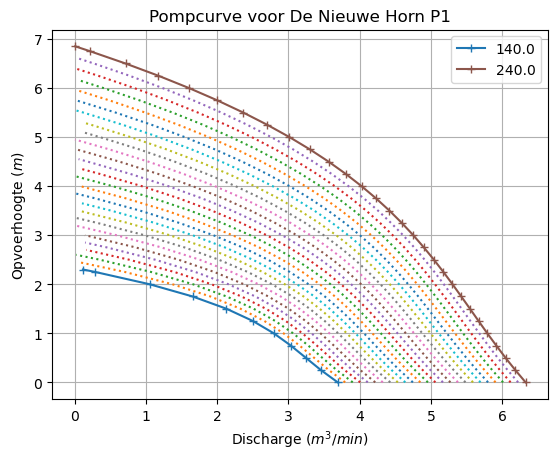

In [4]:
# convert from expected contours format to DataFrame
contours = pd.concat(pd.DataFrame(i) for i in contours).reset_index(drop=True)

# remove negative discharges
contours = contours.where(contours.discharge >= 0.0).dropna().round(3)

# downsample nodes
dfs = []
for contour, df in contours.groupby('speed'):
    indices = list(range(df.index.min(), df.index.max(), downsample_interval)) + [df.index.max()]
    dfs.append(df.loc[indices])
contours = pd.concat(dfs).reset_index(drop=True)

# plot
fig, ax = plt.subplots()
for contour, df in contours.groupby('speed'):
    ax.plot(df['discharge'], df['head'],
            label=contour if contour in [global_tt_min, global_tt_max] else None,
            linestyle='solid' if contour in [global_tt_min, global_tt_max] else 'dotted',
            marker='+' if contour in [global_tt_min, global_tt_max] else None)

ax.set_xlabel('Discharge ($m^3/min$)')
ax.set_ylabel('Opvoerhoogte ($m$)')
ax.set_title(f'Pompcurve voor {object_naam}')
ax.legend()
ax.grid()
fig.savefig(output_dir / f'pompcurve_{object_naam}.png')

### Saving

In [5]:
# xml output
xml_filename = output_dir / f'lookup_table_{object_naam}.xml'
contours.to_xml(
    xml_filename, index=False,
    root_name='pumpSpeedHeadDischargeTable',
    row_name='speedHeadDischargeTableRecord',
    attr_cols=['speed', 'head', 'discharge'])

print(f'Saved {len(set(contours.speed))} contours to "{xml_filename}"')

Saved 26 contours to "output\lookup_table_De Nieuwe Horn P1.xml"


#### **Voorbeeld 2:** Formule als functie van opvoerhoogte (meer dan twee contouren)

In [6]:
############################ SETTINGS ############################
output_dir = Path('./output')           # locatie voor xml en figuur        (Zorg dat de map bestaat)
object_naam = 'De Oostkil P1'           # Naam (sub)locatie

hstat_max = 8.0                         # Bovengrens statische opvoerhoogte (Varieert per locatie)
hstat_min = 0.0                         # Ondergrens statische opvoerhoogte (Logisch om dit op nul (0) te houden)
global_tt_min = 349                     # Ondergrens toerental in pompcurve (Specifiek per pomp)
global_tt_max = 581                     # Bovengrens toerental in pompcurve (Specifiek per pomp)

dhstat = 0.05                           # Stapgrootte opvoerhoogte          (Standaad instelling afdoende)
dtt = 10                                # Contourdichtheid toerental        (Kan verschillen, afhankelijk van de toerental range)
downsample_interval = 10                # Uitdunnen aantal nodes in contour (Specifiek per pomp)
##################################################################

#### <u>Genereer de contouren</u>: definieer hier de locatie specifieke functie en geneer de contouren
Verzamel de contouren in `contours` in deze vorm: `[{'speed': int ,'head': np.array, 'discharge': np.array}]`

In [7]:
# De Oostkill P1
def pc_h(hstat: np.array, c0, c1, c2) -> np.array:
    return c0 + c1 * hstat + c2 * hstat ** 2

# kwargs
coeffients = {global_tt_min: [51.94671, -5.38929, -2.01553],
              402: [58.96474, -4.48193, -1.45015],
              454: [63.31592, -3.95691, -1.25746],
              510: [67.80747, -3.32876, -1.05169],
              global_tt_max: [72.15865, -3.24996, -0.89474]}

# axes
hstat = np.arange(hstat_min, hstat_max + dhstat, dhstat)

# Expected output format
contours = [{'speed': k, 'head': hstat, 'discharge': pc_h(hstat, *v)} for k, v in coeffients.items()]

### Opvullen tussen bekende contouren

In [8]:
def scaling_linear(tt, ttmin, ttmax, min_axis, max_axis):
    '''y=ax+b'''
    return ((tt - ttmin) / (ttmax - ttmin) * (max_axis - min_axis) + min_axis) / max_axis


# convert from expected contours format to DataFrame
contours = pd.concat(pd.DataFrame(i) for i in contours).reset_index(drop=True)

# remove negative discharges
contours = contours.where(contours.discharge >= 0.0).dropna()

# speeds should be integers
contours.speed = contours.speed.astype(int)

interpolated_contours = []

min_speed = contours.speed.min()
max_speed = contours.speed.max()
h_min = contours.iloc[contours.where(contours.speed == min_speed)['discharge'].argmin()]['head']
h_max = contours.iloc[contours.where(contours.speed == max_speed)['discharge'].argmin()]['head']
q_min = contours.iloc[contours.where(contours.speed == min_speed)['head'].argmin()]['discharge']
q_max = contours.iloc[contours.where(contours.speed == max_speed)['head'].argmin()]['discharge']

reference = contours[contours.speed == max_speed]
speeds = list(range(min_speed, max_speed, dtt)) + [max_speed]
for speed in speeds:
    h_scaling = scaling_linear(speed, min_speed, max_speed, q_min, q_max)
    q_scaling = scaling_linear(speed, min_speed, max_speed, q_min, q_max)

    interpolated_contours.append(
        {'speed': speed,
         'head': h_scaling * reference['head'].values,
         'discharge': q_scaling * reference['discharge'].values}
    )
contours = pd.concat(pd.DataFrame(i) for i in interpolated_contours).reset_index(drop=True).round(3)

### Plotting

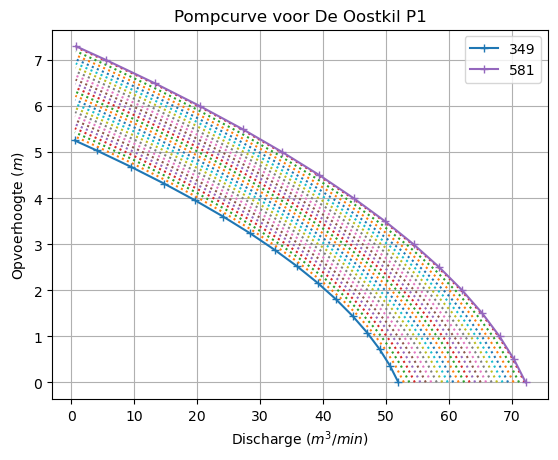

In [9]:
# downsample nodes
dfs = []
for contour, df in contours.groupby('speed'):
    indices = list(range(df.index.min(), df.index.max(), downsample_interval)) + [df.index.max()]
    dfs.append(df.loc[indices])
contours = pd.concat(dfs).reset_index(drop=True)

# plot
fig, ax = plt.subplots()
for contour, df in contours.groupby('speed'):
    ax.plot(df['discharge'], df['head'],
            label=contour if contour in [global_tt_min, global_tt_max] else None,
            linestyle='solid' if contour in [global_tt_min, global_tt_max] else 'dotted',
            marker='+' if contour in [global_tt_min, global_tt_max] else None)

ax.set_xlabel('Discharge ($m^3/min$)')
ax.set_ylabel('Opvoerhoogte ($m$)')
ax.set_title(f'Pompcurve voor {object_naam}')
ax.legend()
ax.grid()
fig.savefig(output_dir / f'pompcurve_{object_naam}.png')

### Saving

In [10]:
# xml output
xml_filename = output_dir / f'lookup_table_{object_naam}.xml'
contours.to_xml(
    xml_filename, index=False,
    root_name='pumpSpeedHeadDischargeTable',
    row_name='speedHeadDischargeTableRecord',
    attr_cols=['speed', 'head', 'discharge'])

print(f'Saved {len(set(contours.speed))} contours to "{xml_filename}"')

Saved 25 contours to "output\lookup_table_De Oostkil P1.xml"


#### **Voorbeeld 3:** Aflezen van de pompcurve (twee contouren)

In [11]:
############################ SETTINGS ############################
output_dir = Path('./output')           # locatie voor xml en figuur        (Zorg dat de map bestaat)
object_naam = 'Altena'                  # Naam (sub)locatie

hstat_max = 8.0                         # Bovengrens statische opvoerhoogte (Varieert per locatie)
hstat_min = 0.0                         # Ondergrens statische opvoerhoogte (Logisch om dit op nul (0) te houden)
global_tt_min = 144                     # Ondergrens toerental in pompcurve (Specifiek per pomp)
global_tt_max = 192                     # Bovengrens toerental in pompcurve (Specifiek per pomp)

dhstat = 0.05                           # Stapgrootte opvoerhoogte          (Standaad instelling afdoende)
dtt = 2                                 # Contourdichtheid toerental        (Kan verschillen, afhankelijk van de toerental range)
downsample_interval = 1                 # Uitdunnen aantal nodes in contour (Specifiek per pomp) (1 = niet uitdunnen)
##################################################################

#### <u>Genereer de contouren</u>: definieer hier de locatie specifieke contouren
Verzamel de contouren in `contours` in deze vorm: `[{'speed': int ,'head': np.array, 'discharge': np.array}]`

In [12]:
# Expected output format
contours = [{'speed': global_tt_min,
             'head': np.array([5.7, 5.0, 4.45, 4.5, 4.3, 4.0, 3.7, 3.0, 1.8, 0.45, 0]),
             'discharge': np.array([0, 50, 93, 110, 130, 150, 170, 200, 250, 300, 312])
             },
             {'speed': global_tt_max,
             'head': np.array([10, 9.15, 8.25, 7.75, 7.9, 7.75, 7.2, 5.8, 4.4, 2.8, 0.8, 0]),
             'discharge': np.array([0, 50, 100, 130, 152, 170, 200, 250, 300, 350, 400, 417])
             }]

### Opvullen tussen contouren (minimaal en maximaal toerental)

In [13]:
def scaling_nonlinear(tt, ttmin, ttmax, min_axis, max_axis):
    '''y=a^x'''
    return np.power(tt / ttmax, np.log(min_axis / max_axis) / np.log(ttmin / ttmax))


# convert from expected contours format to DataFrame
contours = pd.concat(pd.DataFrame(i) for i in contours).reset_index(drop=True)

# remove negative discharges
contours = contours.where(contours.discharge >= 0.0).dropna()

# speeds should be integers
contours.speed = contours.speed.astype(int)

interpolated_contours = []

min_speed = contours.speed.min()
max_speed = contours.speed.max()
h_min = contours.iloc[contours.where(contours.speed == min_speed)['discharge'].argmin()]['head']
h_max = contours.iloc[contours.where(contours.speed == max_speed)['discharge'].argmin()]['head']
q_min = contours.iloc[contours.where(contours.speed == min_speed)['head'].argmin()]['discharge']
q_max = contours.iloc[contours.where(contours.speed == max_speed)['head'].argmin()]['discharge']

reference = contours[contours.speed == max_speed]
speeds = list(range(min_speed, max_speed, dtt)) + [max_speed]
for speed in speeds:
    h_scaling = scaling_nonlinear(speed, min_speed, max_speed, h_min, h_max)
    q_scaling = scaling_linear(speed, min_speed, max_speed, q_min, q_max)

    interpolated_contours.append(
        {'speed': speed,
         'head': h_scaling * reference['head'].values,
         'discharge': q_scaling * reference['discharge'].values}
    )
contours = pd.concat(pd.DataFrame(i) for i in interpolated_contours).reset_index(drop=True).round(3)

### Plotting

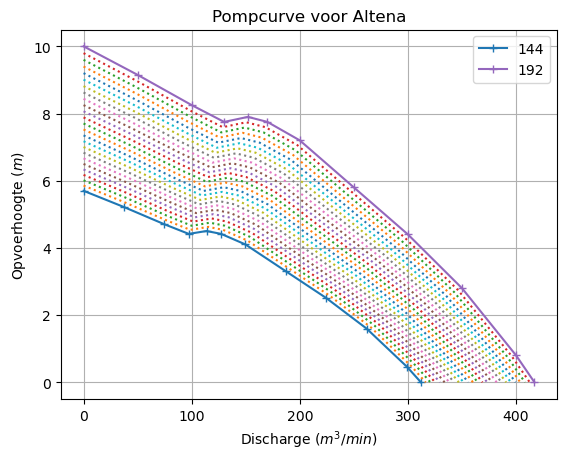

In [14]:
# downsample nodes
dfs = []
for contour, df in contours.groupby('speed'):
    indices = list(range(df.index.min(), df.index.max(), downsample_interval)) + [df.index.max()]
    dfs.append(df.loc[indices])
contours = pd.concat(dfs).reset_index(drop=True)

# plot
fig, ax = plt.subplots()
for contour, df in contours.groupby('speed'):
    ax.plot(df['discharge'], df['head'],
            label=contour if contour in [global_tt_min, global_tt_max] else None,
            linestyle='solid' if contour in [global_tt_min, global_tt_max] else 'dotted',
            marker='+' if contour in [global_tt_min, global_tt_max] else None)

ax.set_xlabel('Discharge ($m^3/min$)')
ax.set_ylabel('Opvoerhoogte ($m$)')
ax.set_title(f'Pompcurve voor {object_naam}')
ax.legend()
ax.grid()
fig.savefig(output_dir / f'pompcurve_{object_naam}.png')

### Saving

In [15]:
# xml output
xml_filename = output_dir / f'lookup_table_{object_naam}.xml'
contours.to_xml(
    xml_filename, index=False,
    root_name='pumpSpeedHeadDischargeTable',
    row_name='speedHeadDischargeTableRecord',
    attr_cols=['speed', 'head', 'discharge'])

print(f'Saved {len(set(contours.speed))} contours to "{xml_filename}"')

Saved 25 contours to "output\lookup_table_Altena.xml"


: 